<a href="https://colab.research.google.com/github/iynnn/Semester-6/blob/main/AI/CNN%20Image%20Classification%20cifar10_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using CIFAR 10 
 The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

# Load and Normalize CIFAR 10

In [ ]:
import torch 
import torchvision
import torchvision.transforms as transforms
import numpy 
import random
torch.manual_seed(43)

In [ ]:
# define our device as the first visible buda device if we have CUDA available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Assumng that we are on a CUDA machine, this should print a cuda device: 
print(device)

cpu


In [ ]:
def seed_all(seed):
    if not seed:
        seed = 43

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    numpy.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
seed = 43
seed_all(seed)
g = torch.Generator()
g.manual_seed(seed)

[ Using Seed :  43  ]


In [ ]:
import torch.utils.data as data
transform  = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]
)

batch_size = 4 


trainset = torchvision.datasets.CIFAR10(root = '/.data', train = True, download = True, transform = transform)
testset = torchvision.datasets.CIFAR10(root = '/.data', train = False, download = True, transform = transform)


train_size = int(len(trainset) * 0.9)
val_size = len(trainset) - train_size
trainset, valset = data.random_split(trainset, [train_size, val_size])



# variabel valloader untuk memuat data dari validation set 
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2, worker_init_fn=seed_worker, generator = g)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle = True, num_workers = 2, worker_init_fn=seed_worker, generator = g)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers = 2, worker_init_fn=seed_worker, generator = g)

classes  =  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: /.data/cifar-10-python.tar.gz
Extracting /.data/cifar-10-python.tar.gz to /.data
Files already downloaded and verified


loader itu untuk meload dataset kemudian nnantinya ada fungsi untuk memisahkan menjadi batch 


batch digunkan untuk membagi satu epoch untuk masuk ke dalam model 

In [ ]:
print("Jumlah record pada data training adalah : " , len(trainset))
print("Jumlah record pada data validation  adalah : " ,len(valset))
print("Jumlah record pada data testing adalah : " ,len(testset))

Jumlah record pada data training adalah :  45000
Jumlah record pada data validation  adalah :  5000
Jumlah record pada data testing adalah :  10000


car   bird  cat   deer 


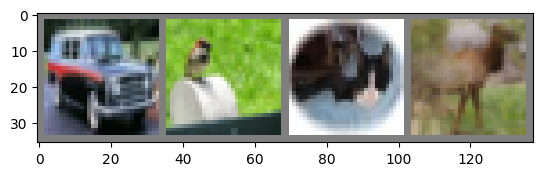

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show image 

def imshow(img):
  img = img / 2 + 0.5 # unnormalize 
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show image 
imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Define Convolutional Neural Network 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()

    # berarti itu nyari sejumlah out_channel itu sesuai yang pengen kita lihat??
    self.conv1 = nn.Conv2d(3,6,5) 
    # banyaknya filter itu sejumlah out_channel 
    # itu bisa disebut juga jumlah filternya juga

    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)


    self.fc1 = nn.Linear(16 * 5 * 5, 120) # ini flattern inputnya dari ukuran dimensi pooling makanya jadi 5*5 *16
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  
  def forward(self, x):
    # torch (size) [4,3, 32, 32] --> 3 itu channelnya RGB,  4 itu batch size nya 
    x = self.pool(F.relu(self.conv1(x)))

    # 
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimention except batch 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()


# Define Loss Function and Optimizer 

In [ ]:
import torch.optim as optim 
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
  # if param_tensor == 'fc1.weight':
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])


In [ ]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


## Untuk mereset parameter model, sehingga dapat dilakukan running model baru tanpa melihat model apa yang telah disimpan sebelumnya

In [ ]:
# model.reset_parameters()
# model.reset_parameters()
for layer in net.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

# Train the Network 

In [ ]:
n_epoch = 10
akurasi = []
temp_akurasi = 0
best_epoch = 0

for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # ini dipindahkan ke GPU 

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0




    correct = 0 
    total = 0 

    # since we're not training, we dont need to calculate the gradients for our outputs 
    with torch.no_grad():
      for data in valloader:
        images, labels = data 

        # calculate output by running images through the network 
        outputs = net(images.to(device)) # ngitung modelnya 

        # the class with the highest energy  is what we choose as prediction 
        _, predicted = torch.max(outputs.data.detach().cpu(), 1) # ini mindahini ke CPU nya 
        total += labels.size(0)
        correct +=  (predicted == labels).sum().item()
# nanti nyimpen model dengan akurasi paling tiinggi, ya dibandingin aja
# jangan lupa nyimpen masing-masing akurasinya 
    acc = 100 * correct // total 
    print(f'Accuracy of the network on the {total} test images : {acc} %')
    akurasi.append(acc)

    # print("Model's state_dict:")
    # for param_tensor in net.state_dict():
    #   if param_tensor == 'fc1.bias' : 
    #     print(param_tensor, "\t", net.state_dict()[param_tensor])

    
    # saving model which the best accuracy 
    if acc > temp_akurasi :
      temp_net = net
      best_epoch = epoch +1 

torch.save(temp_net.state_dict(), './model bagus.pth')
print('Finished Training')

[1,  2000] loss: 2.155
[1,  4000] loss: 1.833
[1,  6000] loss: 1.653
[1,  8000] loss: 1.578
[1, 10000] loss: 1.531
Accuracy of the network on the 5000 test images : 46 %
[2,  2000] loss: 1.449
[2,  4000] loss: 1.387
[2,  6000] loss: 1.385
[2,  8000] loss: 1.377
[2, 10000] loss: 1.342
Accuracy of the network on the 5000 test images : 52 %
[3,  2000] loss: 1.287
[3,  4000] loss: 1.275
[3,  6000] loss: 1.247
[3,  8000] loss: 1.249
[3, 10000] loss: 1.238
Accuracy of the network on the 5000 test images : 51 %
[4,  2000] loss: 1.161
[4,  4000] loss: 1.158
[4,  6000] loss: 1.166
[4,  8000] loss: 1.157
[4, 10000] loss: 1.165
Accuracy of the network on the 5000 test images : 57 %
[5,  2000] loss: 1.063
[5,  4000] loss: 1.087
[5,  6000] loss: 1.080
[5,  8000] loss: 1.107
[5, 10000] loss: 1.094
Accuracy of the network on the 5000 test images : 59 %
[6,  2000] loss: 0.989
[6,  4000] loss: 1.039
[6,  6000] loss: 1.011
[6,  8000] loss: 1.030
[6, 10000] loss: 1.031
Accuracy of the network on the 5000

masih kurang paham gimana cara kerjanya dari model model itu, maksudnya itu model mana yang dipake dan sedang bekerja itu gimana

maksudnya itu kan udah di run, trus di run ulang itu nanti loss entropinya bakalan stuck gitu 

{UDAH SOLVED}

In [ ]:
print("best epoch model original adalah ", best_epoch)

best epoch model original adalah  10


Text(0.5, 0, 'Epoch')

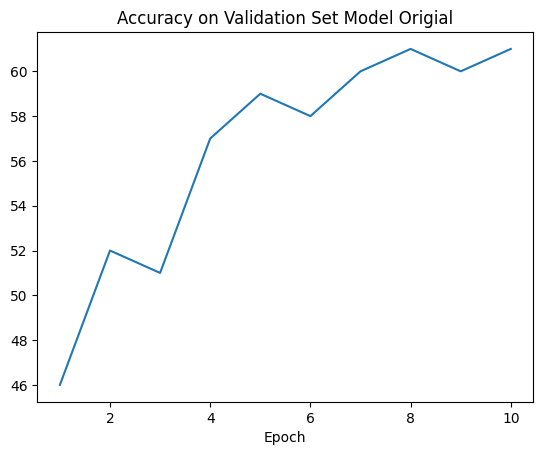

In [ ]:
x = range(1,n_epoch+1)
# plt.plot()
plt.plot(x, akurasi)
plt.title("Accuracy on Validation Set Model Origial")
plt.xlabel("Epoch")

In [ ]:
# # save the training 
# path = './cifar_net.pth'
# torch.save(net.state_dict(), path)

# Test the Network on the Test Data 

In [ ]:
# dataiter =  iter(testloader)
# images, labels = next(dataiter)


# # print images 
# imshow(torchvision.utils.make_grid(images))
# print('Ground Truth : ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# Load the data we've saved
# actually not important, but we have to do it 
net = Net()
net.load_state_dict(torch.load('./model bagus.pth'))


<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted : ', ' '. join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted :  frog  frog  plane horse


In [ ]:
correct = 0 
total = 0 

# since we're not training, we dont need to calculate the gradients for our outputs 
with torch.no_grad():
  for data in testloader:
    images, labels = data 

    # calculate output by running images through the network 
    outputs = net(images)

    # the class with the highest energy  is what we choose as prediction 
    _, predicted = torch.max(outputs.data.detach().cpu(), 1)
    total += labels.size(0)
    correct +=  (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10.000 test images : {100 * correct // total } %')

Accuracy of the network on the 10.000 test images : 61 %


In [ ]:
# prepare to count predicton for each class 
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)

    #collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
      if label == prediction: 
        correct_pred[classes[label]] +=1
      total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class : {classname:5s} is {accuracy :.1f}%')


Accuracy for class : plane is 67.1%
Accuracy for class : car   is 72.1%
Accuracy for class : bird  is 43.6%
Accuracy for class : cat   is 51.4%
Accuracy for class : deer  is 51.3%
Accuracy for class : dog   is 48.9%
Accuracy for class : frog  is 69.5%
Accuracy for class : horse is 66.4%
Accuracy for class : ship  is 74.3%
Accuracy for class : truck is 66.9%


# Training on GPU 

In [ ]:
# define our device as the first visible buda device if we have CUDA available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Assumng that we are on a CUDA machine, this should print a cuda device: 
print(device)

cpu


In [ ]:
# Assume that our device has a CUDA 
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)